
#  US Accidents: Batch-Wise Data Processing & Severity Prediction  

## Summary  
The **US Accidents dataset** (~7.7M rows, 2016–2023) is one of the largest open traffic accident datasets.  
A key challenge is that the dataset is **too large to process in memory at once**.  

To solve this, I designed a **batch-wise machine learning pipeline** using `chunksize` and `partial_fit`.  
This approach mimics real-world big data workflows and shows ability to handle **scalability challenges**.  
 
  
  


In [1]:
# important libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import folium
import networkx as nx
import category_encoders as ce
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score, KFold
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve,balanced_accuracy_score,precision_recall_curve,average_precision_score, precision_score,recall_score, auc


## 2. Data Loading (Batch-Wise)

In [2]:
# Load dataset in chunks
file_path = "input/US_Accidents_March23.csv"

# Read the dataset
chunksize = 1000000
data_iter = pd.read_csv(file_path, chunksize=chunksize)
df = next(data_iter)
df


ID   Source  Severity           Start_Time  \
0             A-1  Source2         3  2016-02-08 05:46:00   
1             A-2  Source2         2  2016-02-08 06:07:59   
2             A-3  Source2         2  2016-02-08 06:49:27   
3             A-4  Source2         3  2016-02-08 07:23:34   
4             A-5  Source2         2  2016-02-08 07:39:07   
...           ...      ...       ...                  ...   
999995  A-1009761  Source2         2  2021-06-10 04:09:01   
999996  A-1009762  Source2         2  2021-06-10 04:09:54   
999997  A-1009763  Source2         2  2021-06-10 05:17:52   
999998  A-1009764  Source2         2  2021-06-10 05:24:46   
999999  A-1009765  Source2         2  2021-06-10 05:26:15   

                   End_Time  Start_Lat  Start_Lng  End_Lat  End_Lng  \
0       2016-02-08 11:00:00  39.865147 -84.058723      NaN      NaN   
1       2016-02-08 06:37:59  39.928059 -82.831184      NaN      NaN   
2       2016-02-08 07:19:27  39.063148 -84.032608      NaN      NaN   
3       2016-02-08 07:53:34  39.747753 -84.205582      NaN      NaN   
4       2016-02-08 08:09:07  39.627781 -84.188354      NaN      NaN   
...                     ...        ...        ...      ...      ...   
999995  2021-06-10 05:45:47  28.436939 -81.348747      NaN      NaN   
999996  2021-06-10 05:45:44  28.426664 -81.307961      NaN      NaN   
999997  2021-06-10 06:42:43  27.765680 -82.641678      NaN      NaN   
999998  2021-06-10 06:42:42  27.901506 -82.637878      NaN      NaN   
999999  2021-06-10 09:30:38  28.302280 -82.704132      NaN      NaN   

        Distance(mi)  ... Roundabout Station   Stop Traffic_Calming  \
0               0.01  ...      False   False  False           False   
1               0.01  ...      False   False  False           False   
2               0.01  ...      False   False  False           False   
3               0.01  ...      False   False  False           False   
4               0.01  ...      False   False  False           False   
...              ...  ...        ...     ...    ...             ...   
999995          0.00  ...      False   False  False           False   
999996          0.00  ...      False   False  False           False   
999997          0.00  ...      False   False  False           False   
999998          0.00  ...      False   False  False           False   
999999          0.00  ...      False   False  False           False   

       Traffic_Signal Turning_Loop Sunrise_Sunset Civil_Twilight  \
0               False        False          Night          Night   
1               False        False          Night          Night   
2                True        False          Night          Night   
3               False        False          Night            Day   
4                True        False            Day            Day   
...               ...          ...            ...            ...   
999995           True        False          Night          Night   
999996          False        False          Night          Night   
999997           True        False          Night          Night   
999998          False        False          Night          Night   
999999           True        False          Night          Night   

       Nautical_Twilight Astronomical_Twilight  
0                  Night                 Night  
1                  Night                   Day  
2                    Day                   Day  
3                    Day                   Day  
4                    Day                   Day  
...                  ...                   ...  
999995             Night                 Night  
999996             Night                 Night  
999997             Night                   Day  
999998             Night                   Day  
999999             Night                   Day  

[1000000 rows x 46 columns]

In [3]:
df.tail()

ID   Source  Severity           Start_Time  \
999995  A-1009761  Source2         2  2021-06-10 04:09:01   
999996  A-1009762  Source2         2  2021-06-10 04:09:54   
999997  A-1009763  Source2         2  2021-06-10 05:17:52   
999998  A-1009764  Source2         2  2021-06-10 05:24:46   
999999  A-1009765  Source2         2  2021-06-10 05:26:15   

                   End_Time  Start_Lat  Start_Lng  End_Lat  End_Lng  \
999995  2021-06-10 05:45:47  28.436939 -81.348747      NaN      NaN   
999996  2021-06-10 05:45:44  28.426664 -81.307961      NaN      NaN   
999997  2021-06-10 06:42:43  27.765680 -82.641678      NaN      NaN   
999998  2021-06-10 06:42:42  27.901506 -82.637878      NaN      NaN   
999999  2021-06-10 09:30:38  28.302280 -82.704132      NaN      NaN   

        Distance(mi)  ... Roundabout Station   Stop Traffic_Calming  \
999995           0.0  ...      False   False  False           False   
999996           0.0  ...      False   False  False           False   
999997           0.0  ...      False   False  False           False   
999998           0.0  ...      False   False  False           False   
999999           0.0  ...      False   False  False           False   

       Traffic_Signal Turning_Loop Sunrise_Sunset Civil_Twilight  \
999995           True        False          Night          Night   
999996          False        False          Night          Night   
999997           True        False          Night          Night   
999998          False        False          Night          Night   
999999           True        False          Night          Night   

       Nautical_Twilight Astronomical_Twilight  
999995             Night                 Night  
999996             Night                 Night  
999997             Night                   Day  
999998             Night                   Day  
999999             Night                   Day  

[5 rows x 46 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 46 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   ID                     1000000 non-null  object 
 1   Source                 1000000 non-null  object 
 2   Severity               1000000 non-null  int64  
 3   Start_Time             1000000 non-null  object 
 4   End_Time               1000000 non-null  object 
 5   Start_Lat              1000000 non-null  float64
 6   Start_Lng              1000000 non-null  float64
 7   End_Lat                0 non-null        float64
 8   End_Lng                0 non-null        float64
 9   Distance(mi)           1000000 non-null  float64
 10  Description            999999 non-null   object 
 11  Street                 998288 non-null   object 
 12  City                   999972 non-null   object 
 13  County                 1000000 non-null  object 
 14  State              

In [5]:
df.describe(include='all')

ID   Source        Severity           Start_Time  \
count     1000000  1000000  1000000.000000              1000000   
unique    1000000        2             NaN               971723   
top     A-1009726  Source2             NaN  2022-03-11 04:00:16   
freq            1   965971             NaN                   55   
mean          NaN      NaN        2.320200                  NaN   
std           NaN      NaN        0.548478                  NaN   
min           NaN      NaN        1.000000                  NaN   
25%           NaN      NaN        2.000000                  NaN   
50%           NaN      NaN        2.000000                  NaN   
75%           NaN      NaN        3.000000                  NaN   
max           NaN      NaN        4.000000                  NaN   

                   End_Time       Start_Lat       Start_Lng  End_Lat  End_Lng  \
count               1000000  1000000.000000  1000000.000000      0.0      0.0   
unique               972764             NaN             NaN      NaN      NaN   
top     2016-10-14 19:50:00             NaN             NaN      NaN      NaN   
freq                     24             NaN             NaN      NaN      NaN   
mean                    NaN       36.059323      -94.753951      NaN      NaN   
std                     NaN        4.906870       17.391816      NaN      NaN   
min                     NaN       24.554800     -124.497414      NaN      NaN   
25%                     NaN       32.925510     -117.370224      NaN      NaN   
50%                     NaN       35.258339      -87.957626      NaN      NaN   
75%                     NaN       40.113201      -80.919167      NaN      NaN   
max                     NaN       48.998085      -68.160789      NaN      NaN   

          Distance(mi)  ... Roundabout  Station     Stop Traffic_Calming  \
count   1000000.000000  ...    1000000  1000000  1000000         1000000   
unique             NaN  ...          2        2        2               2   
top                NaN  ...      False    False    False           False   
freq               NaN  ...     999973   972026   970784          999113   
mean          0.167486  ...        NaN      NaN      NaN             NaN   
std           1.427785  ...        NaN      NaN      NaN             NaN   
min           0.000000  ...        NaN      NaN      NaN             NaN   
25%           0.000000  ...        NaN      NaN      NaN             NaN   
50%           0.000000  ...        NaN      NaN      NaN             NaN   
75%           0.010000  ...        NaN      NaN      NaN             NaN   
max         336.570007  ...        NaN      NaN      NaN             NaN   

       Traffic_Signal Turning_Loop Sunrise_Sunset Civil_Twilight  \
count         1000000      1000000         998364         998364   
unique              2            1              2              2   
top             False        False            Day            Day   
freq           790103      1000000         726997         777856   
mean              NaN          NaN            NaN            NaN   
std               NaN          NaN            NaN            NaN   
min               NaN          NaN            NaN            NaN   
25%               NaN          NaN            NaN            NaN   
50%               NaN          NaN            NaN            NaN   
75%               NaN          NaN            NaN            NaN   
max               NaN          NaN            NaN            NaN   

       Nautical_Twilight Astronomical_Twilight  
count             998364                998364  
unique                 2                     2  
top                  Day                   Day  
freq              828635                868275  
mean                 NaN                   NaN  
std                  NaN                   NaN  
min                  NaN                   NaN  
25%                  NaN                   NaN  
50%                  NaN                   NaN  
75%              

In [6]:
# cheacking the missing values
missing_value_counts = df.isnull().sum()
missing_value_counts[:46]

ID                             0
Source                         0
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                  1000000
End_Lng                  1000000
Distance(mi)                   0
Description                    1
Street                      1712
City                          28
County                         0
State                          0
Zipcode                      136
Country                        0
Timezone                     451
Airport_Code                1432
Weather_Timestamp           9927
Temperature(F)             15298
Wind_Chill(F)             460589
Humidity(%)                16553
Pressure(in)               12376
Visibility(mi)             18931
Wind_Direction             13570
Wind_Speed(mph)           100398
Precipitation(in)         475316
Weather_Condition          18211
Amenity                        0
Bump      

In [7]:
# percentance of missing values
total_cols = np.prod(df.shape)
total_missing = missing_value_counts.sum()
missing_values_per = (total_missing/total_cols )* 100
print(f'Total percent of data that is missing {missing_values_per:2f}')

Total percent of data that is missing 6.851028


### The dataset contains about 9% missing values in total.

However, the missingness is not evenly distributed: while most columns have little or no missing data, a few features are severely affected (very high proportion of NaNs).

In [8]:
# let's check the missing %  values for each cols 
missing_per_col = (missing_value_counts / len(df)) * 100
missing_per_col = missing_per_col[missing_per_col > 0].sort_values(ascending=False)
missing_per_col.head(7)

End_Lat              100.0000
End_Lng              100.0000
Precipitation(in)     47.5316
Wind_Chill(F)         46.0589
Wind_Speed(mph)       10.0398
Visibility(mi)         1.8931
Weather_Condition      1.8211
dtype: float64

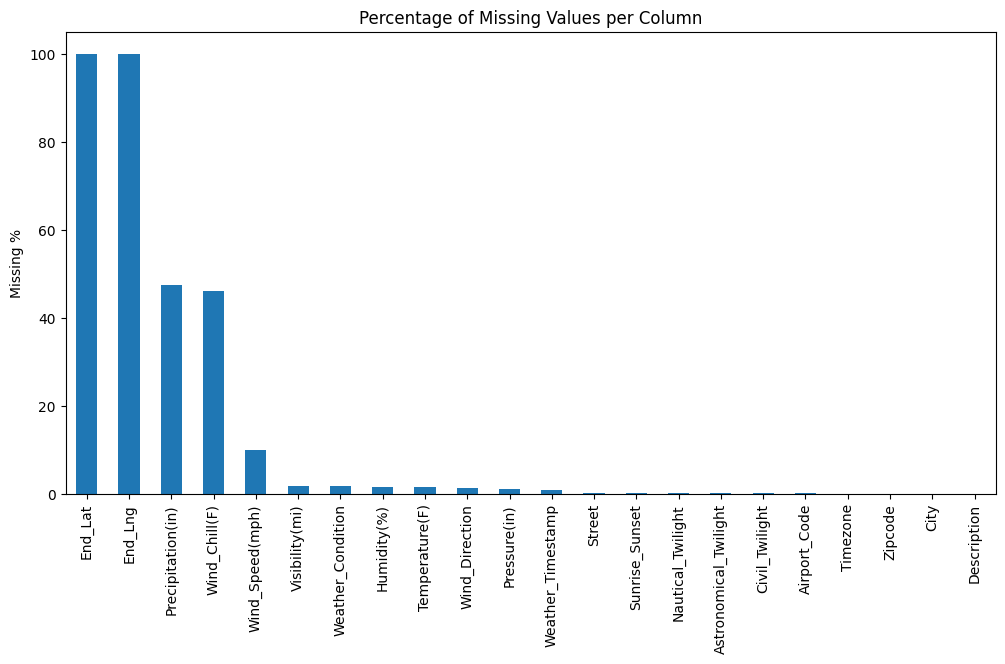

In [9]:
# plotting the missing values
missing_per_col.plot(kind='bar', figsize=(12,6))
plt.title("Percentage of Missing Values per Column")
plt.ylabel("Missing %")
plt.show()

In [10]:
# memeroy usage of the data
df.memory_usage(deep=True).sum() / 1024**2

np.float64(1401.4023790359497)

In [11]:
# checking the duplicates
df.duplicated().sum()

np.int64(0)

In [12]:
# Separate categorical and numerical columns
cat_cols = df.select_dtypes(include='object').columns
num_cols = df.select_dtypes(exclude='object').columns

print("Categorical columns and their unique values:")
print("*" * 30)
for col in cat_cols:
    print(f"{col}: {df[col].nunique()} unique values")

print("*" * 30)
print("\nNumerical columns:")
print(list(num_cols))

Categorical columns and their unique values:
******************************
ID: 1000000 unique values
Source: 2 unique values
Start_Time: 971723 unique values
End_Time: 972764 unique values
Description: 763266 unique values
Street: 86159 unique values
City: 8741 unique values
County: 1429 unique values
State: 49 unique values
Zipcode: 161288 unique values
Country: 1 unique values
Timezone: 4 unique values
Airport_Code: 1709 unique values
Weather_Timestamp: 223797 unique values
Wind_Direction: 24 unique values
Weather_Condition: 107 unique values
Sunrise_Sunset: 2 unique values
Civil_Twilight: 2 unique values
Nautical_Twilight: 2 unique values
Astronomical_Twilight: 2 unique values
******************************

Numerical columns:
['Severity', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No

In [13]:
# class balance
df['Severity'].value_counts()

Severity
2    606235
3    352187
1     38381
4      3197
Name: count, dtype: int64

In [14]:
#checking all the unique values for categorical columns
for col in cat_cols:
    print(f"\nColumn: {col}")
    print(f"Unique values: {df[col].nunique()}")
    print("Top most frequent values:")
    print(df[col].value_counts().head(5))
    print("*" * 60)


Column: ID
Unique values: 1000000
Top most frequent values:
ID
A-1009726    1
A-1009727    1
A-1009728    1
A-1009729    1
A-1009730    1
Name: count, dtype: int64
************************************************************

Column: Source
Unique values: 2
Top most frequent values:
Source
Source2    965971
Source3     34029
Name: count, dtype: int64
************************************************************

Column: Start_Time
Unique values: 971723
Top most frequent values:
Start_Time
2022-03-11 04:00:16    55
2022-04-22 07:39:08    52
2021-07-28 04:06:41    48
2021-12-08 04:05:56    43
2021-11-03 04:00:48    39
Name: count, dtype: int64
************************************************************

Column: End_Time
Unique values: 972764
Top most frequent values:
End_Time
2016-10-14 19:50:00    24
2016-10-14 16:30:00    18
2016-10-14 18:30:00    16
2016-04-26 22:30:00    15
2016-07-16 16:50:00    14
Name: count, dtype: int64
**********************************************************

In [15]:
#checking all the unique values for numeric columns
for col in num_cols:
    print(f"\nColumn: {col}")
    print(f"Unique values: {df[col].nunique()}")
    print("Top most frequent values:")
    print(df[col].value_counts().head(5))
    print("*" * 60)


Column: Severity
Unique values: 4
Top most frequent values:
Severity
2    606235
3    352187
1     38381
4      3197
Name: count, dtype: int64
************************************************************

Column: Start_Lat
Unique values: 404851
Top most frequent values:
Start_Lat
42.476501    318
34.858849    264
37.808498    263
33.941364    262
33.781532    251
Name: count, dtype: int64
************************************************************

Column: Start_Lng
Unique values: 392924
Top most frequent values:
Start_Lng
-83.111794     318
-82.260422     264
-122.366852    263
-118.096634    261
-84.390869     256
Name: count, dtype: int64
************************************************************

Column: End_Lat
Unique values: 0
Top most frequent values:
Series([], Name: count, dtype: int64)
************************************************************

Column: End_Lng
Unique values: 0
Top most frequent values:
Series([], Name: count, dtype: int64)
******************************

# Data Loading and Inspection Analysis


The dataset was loaded and inspected for structural issues before analysis. Key steps included:

- **Initial Inspection:** Verified dataset shape, column names, and data types.  
- **Duplicates:** Checked and removed duplicate records to avoid bias.  
- **Data Types:** Converted relevant columns into appropriate datetime objects.  


# Data Handling

In [16]:
# Drop columns 
cols_to_drop = ['ID', 'Description', 'Street', 'Zipcode', 'Weather_Timestamp',
                'End_Lat', 'End_Lng', 'Wind_Chill(F)', 'Country']
df.drop(columns=cols_to_drop, inplace=True)
df.head()

Source  Severity           Start_Time             End_Time  Start_Lat  \
0  Source2         3  2016-02-08 05:46:00  2016-02-08 11:00:00  39.865147   
1  Source2         2  2016-02-08 06:07:59  2016-02-08 06:37:59  39.928059   
2  Source2         2  2016-02-08 06:49:27  2016-02-08 07:19:27  39.063148   
3  Source2         3  2016-02-08 07:23:34  2016-02-08 07:53:34  39.747753   
4  Source2         2  2016-02-08 07:39:07  2016-02-08 08:09:07  39.627781   

   Start_Lng  Distance(mi)          City      County State  ... Roundabout  \
0 -84.058723          0.01        Dayton  Montgomery    OH  ...      False   
1 -82.831184          0.01  Reynoldsburg    Franklin    OH  ...      False   
2 -84.032608          0.01  Williamsburg    Clermont    OH  ...      False   
3 -84.205582          0.01        Dayton  Montgomery    OH  ...      False   
4 -84.188354          0.01        Dayton  Montgomery    OH  ...      False   

  Station   Stop  Traffic_Calming  Traffic_Signal  Turning_Loop  \
0   False  False            False           False         False   
1   False  False            False           False         False   
2   False  False            False            True         False   
3   False  False            False           False         False   
4   False  False            False            True         False   

  Sunrise_Sunset  Civil_Twilight  Nautical_Twilight Astronomical_Twilight  
0          Night           Night              Night                 Night  
1          Night           Night              Night                   Day  
2          Night           Night                Day                   Day  
3          Night             Day                Day                   Day  
4            Day             Day                Day                   Day  

[5 rows x 37 columns]

In [17]:
# Impute missing numeric values
numeric_impute_median = ['Precipitation(in)', 'Wind_Speed(mph)', 'Visibility(mi)']
for col in numeric_impute_median:
    df[col].fillna(df[col].median(), inplace=True)

In [18]:
# Impute missing categorical values
categorical_impute_mode = ['Wind_Direction']
for col in categorical_impute_mode:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [19]:
# Wind_Direction: unify "CALM" / "Calm"
df['Wind_Direction'] = df['Wind_Direction'].str.upper()

In [20]:
# Weather_Condition: group into main buckets
def normalize_weather(x):
    if pd.isnull(x):
        return 'Unknown'
    x = x.lower()
    if any(word in x for word in ['clear', 'fair']):
        return 'Clear'
    elif any(word in x for word in ['cloud', 'overcast', 'partly']):
        return 'Cloudy'
    elif any(word in x for word in ['rain', 'drizzle', 'shower', 'thunder']):
        return 'Rain'
    elif any(word in x for word in ['snow', 'sleet', 'flurries']):
        return 'Snow'
    elif any(word in x for word in ['fog', 'mist', 'haze']):
        return 'Fog'
    else:
        return 'Other'

In [21]:
df['Weather_Condition'] = df['Weather_Condition'].apply(normalize_weather)
df['Weather_Condition']

0           Rain
1           Rain
2         Cloudy
3         Cloudy
4         Cloudy
           ...  
999995     Clear
999996     Clear
999997     Clear
999998     Clear
999999     Clear
Name: Weather_Condition, Length: 1000000, dtype: object

In [22]:
# Checking missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
Source                       0
Severity                     0
Start_Time                   0
End_Time                     0
Start_Lat                    0
Start_Lng                    0
Distance(mi)                 0
City                        28
County                       0
State                        0
Timezone                   451
Airport_Code              1432
Temperature(F)           15298
Humidity(%)              16553
Pressure(in)             12376
Visibility(mi)               0
Wind_Direction               0
Wind_Speed(mph)              0
Precipitation(in)            0
Weather_Condition            0
Amenity                      0
Bump                         0
Crossing                     0
Give_Way                     0
Junction                     0
No_Exit                      0
Railway                      0
Roundabout                   0
Station                      0
Stop                         0
Traffic_Calming              0
Traffic_Sig

In [23]:
#Handling Remaining Missing Values
#Fill small missing values in categorical columns
df['City'].fillna('Unknown', inplace=True)
df['Timezone'].fillna('Unknown', inplace=True)
df['Airport_Code'].fillna('Unknown', inplace=True)
df['Sunrise_Sunset'].fillna('Unknown', inplace=True)
df['Civil_Twilight'].fillna('Unknown', inplace=True)
df['Nautical_Twilight'].fillna('Unknown', inplace=True)
df['Astronomical_Twilight'].fillna('Unknown', inplace=True)

#Impute missing numeric weather features with median
weather_numeric = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)']
for col in weather_numeric:
    df[col].fillna(df[col].median(), inplace=True)

#Once again Verifying all missing values are handleded or not
print("Missing values after imputation:")
print(df.isnull().sum().sum())  # total count

Missing values after imputation:
0


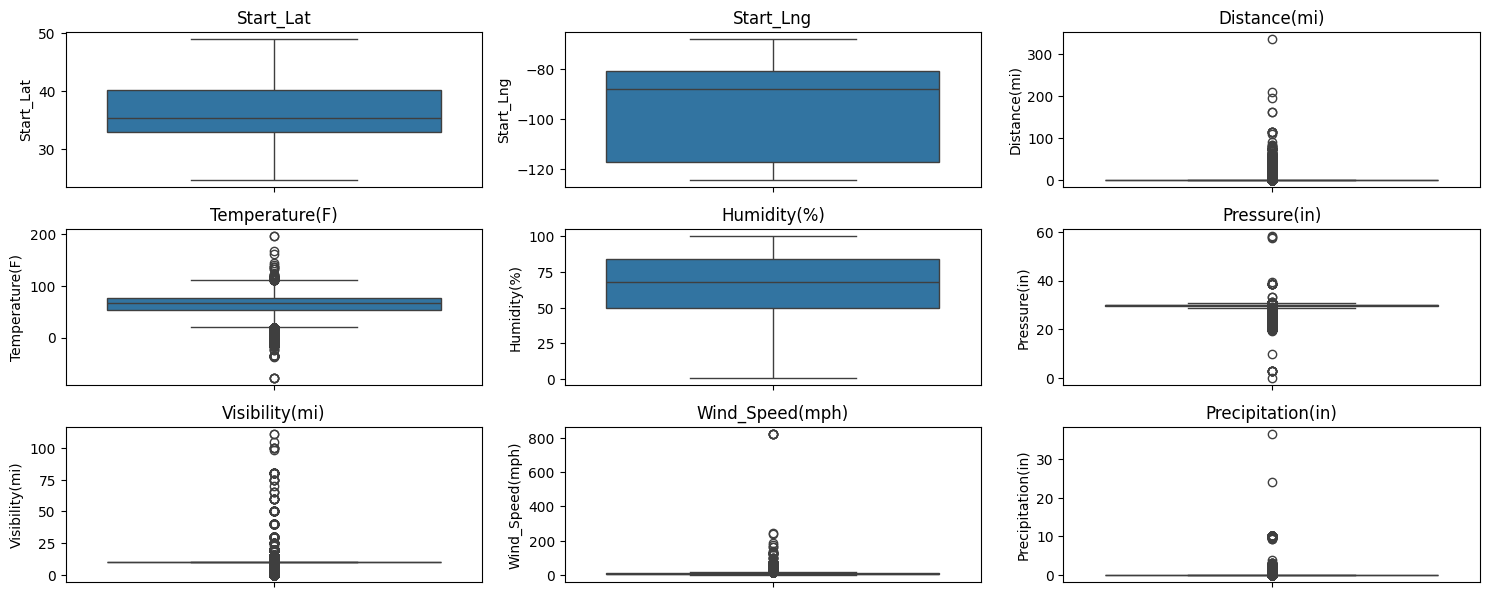

In [24]:
#Outliers detection
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols.remove('Severity')  # exclude target

plt.figure(figsize=(15,8))
for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols)//3 + 1, 3, i+1)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

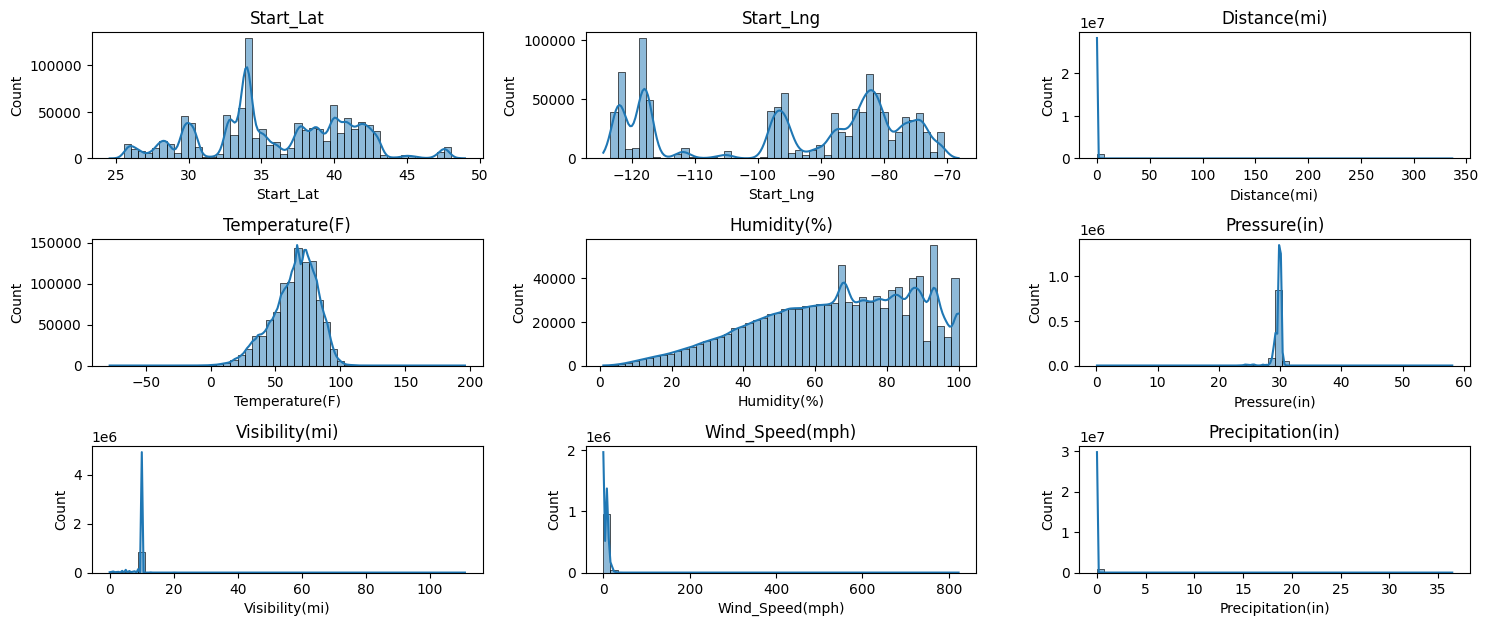

In [25]:
plt.figure(figsize=(15,8))
for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols)//3 + 1, 3, i+1)
    sns.histplot(df[col], kde=True, bins=50)
    plt.title(col)
plt.tight_layout()
plt.show()


In [26]:
#Capping method
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, df[col])


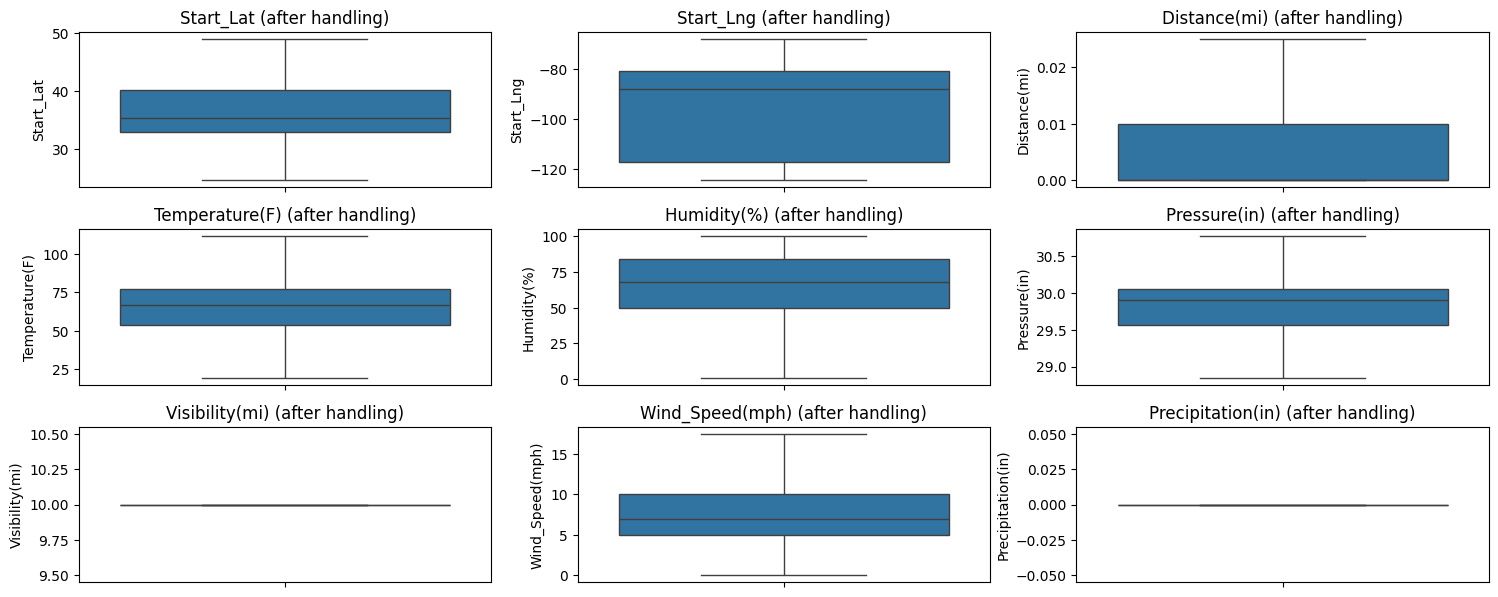

In [27]:
#Visualize After Outlier Handling
plt.figure(figsize=(15,8))
for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols)//3 + 1, 3, i+1)
    sns.boxplot(y=df[col])
    plt.title(f"{col} (after handling)")
plt.tight_layout()
plt.show()


## Data Handling & Preprocessing

A high-quality dataset is the foundation of any robust machine learning pipeline.  
To ensure integrity and reliability, multiple stages of preprocessing were carried out:

### Missing Value Treatment
- **Numeric features** → Imputed using statistical measures (**mean/median**, depending on distribution).  
- **Categorical features** → Imputed using the most frequent category (**mode**).  
- **Remaining missing values** → Re-examined and handled systematically to prevent data leakage or bias.  

### Outlier Detection & Treatment
- Applied the **Interquartile Range (IQR)** method to identify and cap extreme values in key numerical columns.  
- This ensured that unusual records (e.g., abnormal traffic counts or weather readings) did not distort model learning.  

---

**Insight:**  
After these steps, the dataset became consistent, balanced in scale, and ready for downstream modeling.  

**Takeaway:**  
A structured preprocessing pipeline — combining imputation and outlier treatment — transformed raw accident logs into reliable, high-quality training data, reducing noise and improving model robustness.


# Exploratory Data Analysis

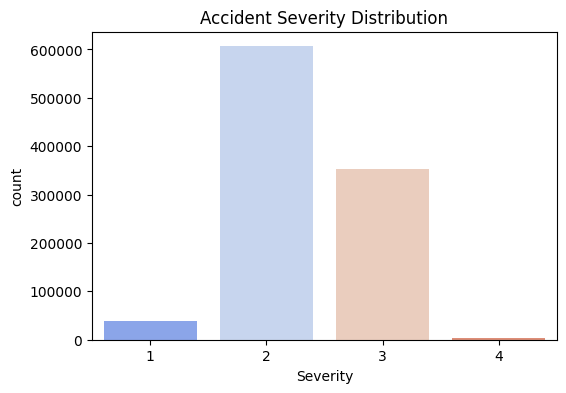

Severity percentage distribution:
 Severity
2    60.6235
3    35.2187
1     3.8381
4     0.3197
Name: proportion, dtype: float64


In [28]:
#Target Variable Analysis
plt.figure(figsize=(6,4))
sns.countplot(x='Severity', data=df, palette="coolwarm")
plt.title('Accident Severity Distribution')
plt.show()

# Percentage distribution
severity_percent = df['Severity'].value_counts(normalize=True) * 100
print("Severity percentage distribution:\n", severity_percent)

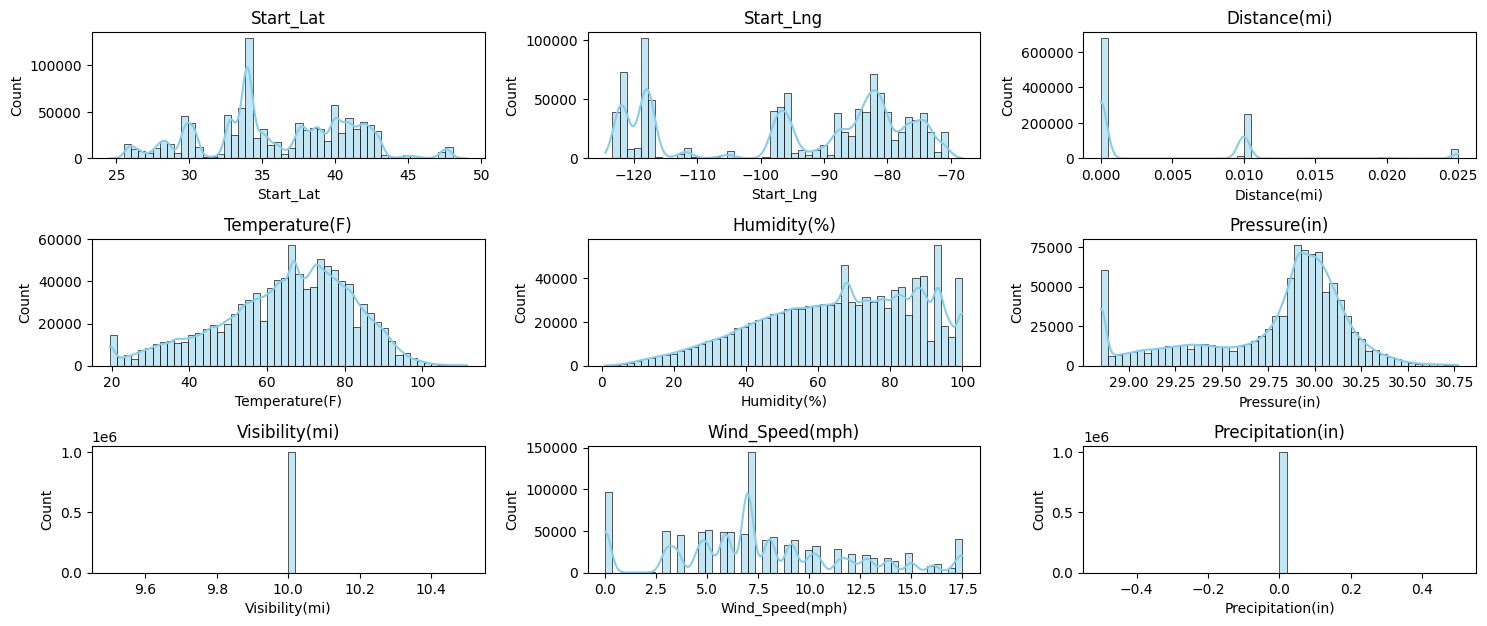

In [29]:
#Numerical Feature Distributions
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols.remove('Severity')

plt.figure(figsize=(15,8))
for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols)//3 + 1, 3, i+1)
    sns.histplot(df[col], kde=True, bins=50, color='skyblue')
    plt.title(col)
plt.tight_layout()
plt.show()

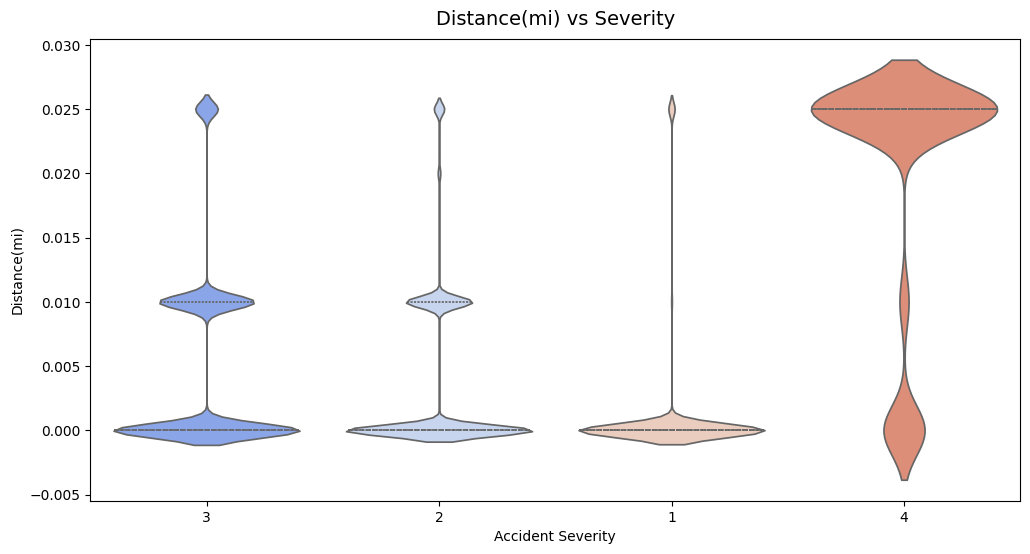

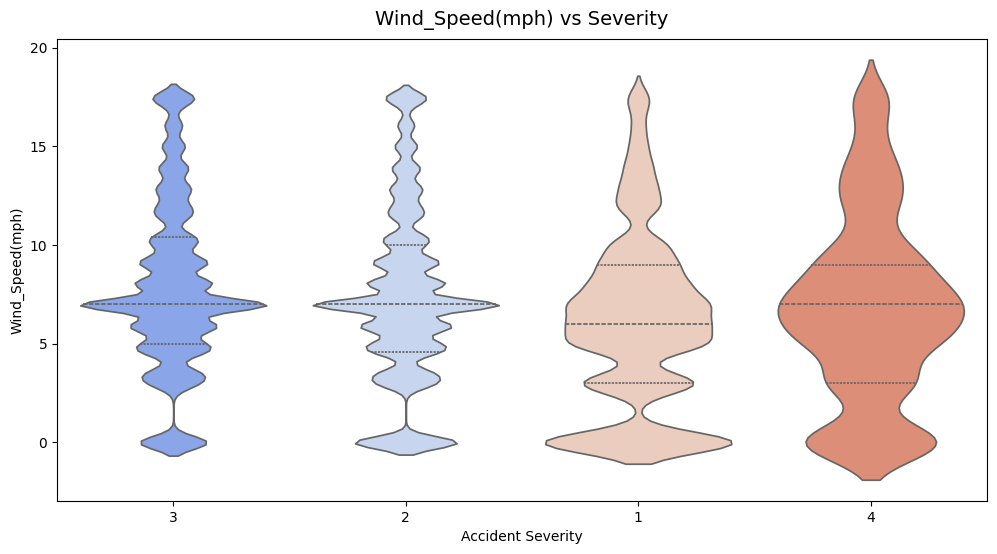

In [30]:
# Function for violin plots
def plot_violin(df, feature, target="Severity"):
    plt.figure(figsize=(12,6))
    sns.violinplot(
        x=df[target].astype(str),
        y=df[feature],
        palette="coolwarm",
        inner="quartile"
    )
    plt.title(f"{feature} vs {target}", fontsize=14, pad=10)
    plt.xlabel("Accident Severity")
    plt.ylabel(feature)
    plt.show()

features = ["Distance(mi)","Wind_Speed(mph)"]

for f in features:
    plot_violin(df, f)

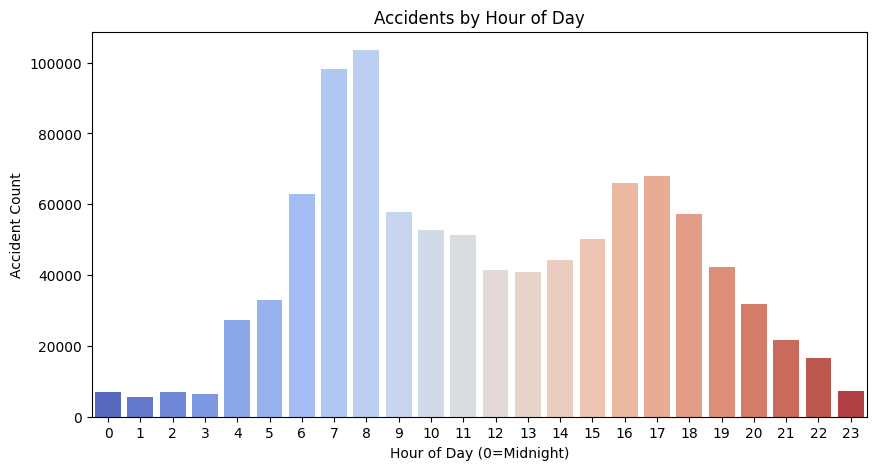

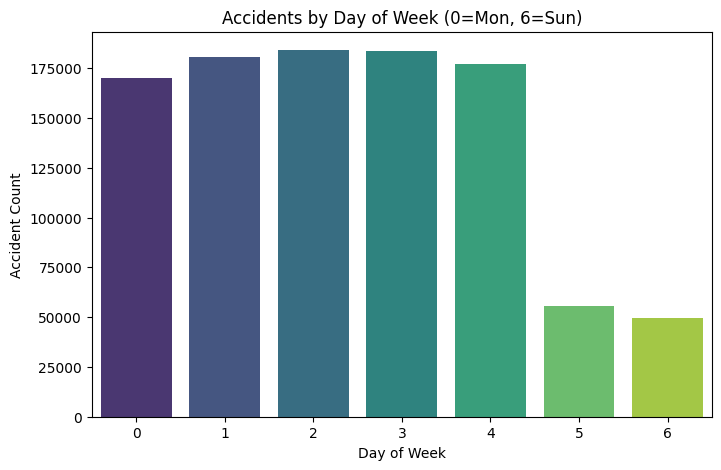

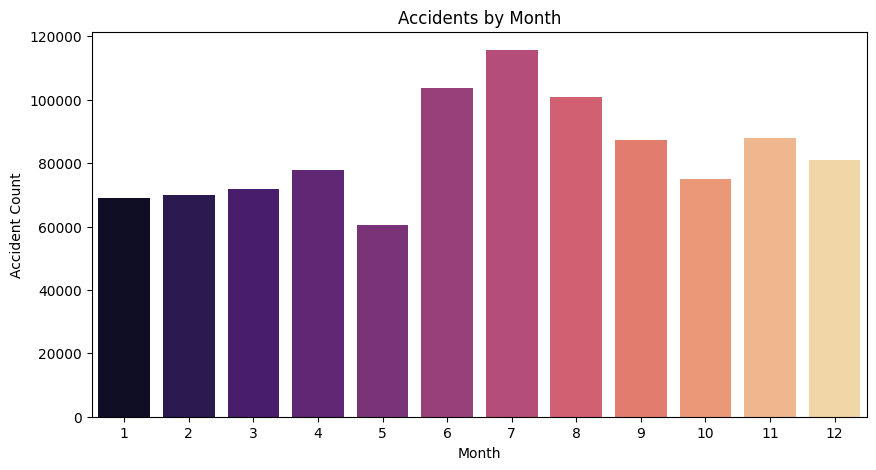

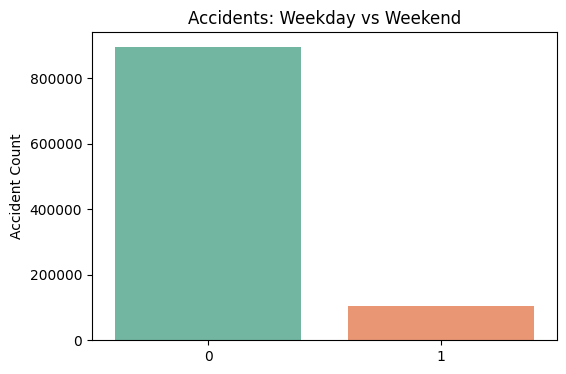

In [31]:
# Convert Start_Time to datetime first
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')

# Extract time-based features BEFORE encoding
df['Hour'] = df['Start_Time'].dt.hour
df['DayOfWeek'] = df['Start_Time'].dt.dayofweek
df['Month'] = df['Start_Time'].dt.month
df['Weekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

#Accidents by Hour
plt.figure(figsize=(10,5))
sns.countplot(x='Hour', data=df, palette='coolwarm', order=sorted(df['Hour'].unique()))
plt.title('Accidents by Hour of Day')
plt.xlabel("Hour of Day (0=Midnight)")
plt.ylabel("Accident Count")
plt.show()


#Accidents by Day of Week
plt.figure(figsize=(8,5))
sns.countplot(x='DayOfWeek', data=df, palette='viridis')
plt.title("Accidents by Day of Week (0=Mon, 6=Sun)")
plt.xlabel("Day of Week")
plt.ylabel("Accident Count")
plt.show()


#Accidents by Month
plt.figure(figsize=(10,5))
sns.countplot(x='Month', data=df, palette='magma')
plt.title("Accidents by Month")
plt.xlabel("Month")
plt.ylabel("Accident Count")
plt.show()


#Weekday vs Weekend
plt.figure(figsize=(6,4))
sns.countplot(x='Weekend', data=df, palette='Set2')
plt.title("Accidents: Weekday vs Weekend")
plt.xlabel("")
plt.ylabel("Accident Count")
plt.show()



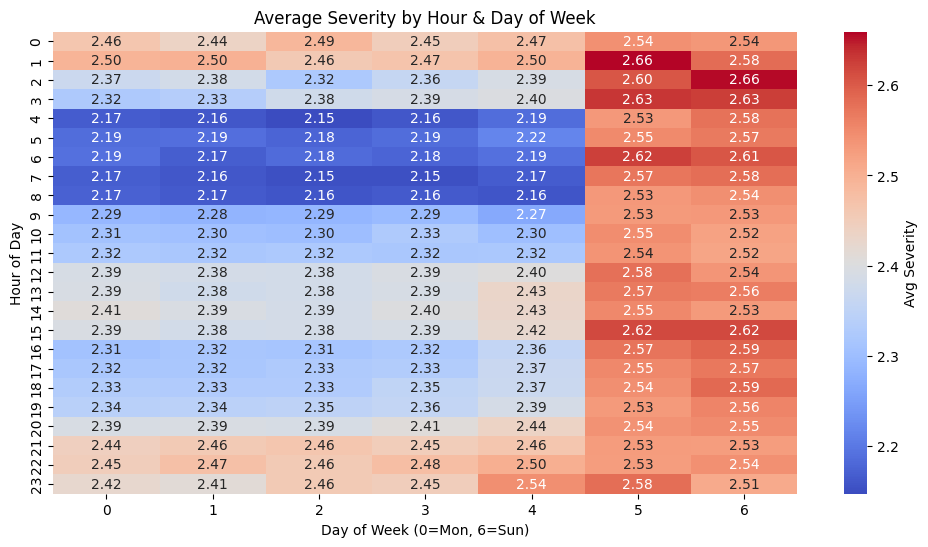

In [32]:
#Heatmap: Severity by Hour & DayOfWeek
hour_day = df.groupby(['Hour','DayOfWeek'])['Severity'].mean().unstack()

plt.figure(figsize=(12,6))
sns.heatmap(hour_day, cmap='coolwarm', annot=True, fmt=".2f", cbar_kws={'label': 'Avg Severity'})
plt.title("Average Severity by Hour & Day of Week")
plt.xlabel("Day of Week (0=Mon, 6=Sun)")
plt.ylabel("Hour of Day")
plt.show()

In [33]:
# Geospatial Clusters
# Sample for performance
sample_df = df[['Start_Lat','Start_Lng']].dropna().sample(10000)
kmeans = KMeans(n_clusters=6, random_state=42).fit(sample_df)
sample_df['Cluster'] = kmeans.labels_

m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)
for _, row in sample_df.iterrows():
    folium.CircleMarker(
        location=[row['Start_Lat'], row['Start_Lng']],
        radius=3,
        color=f"C{row['Cluster']}",
        fill=True,
        fill_opacity=0.7
    ).add_to(m)
m  # Interactive map in notebook


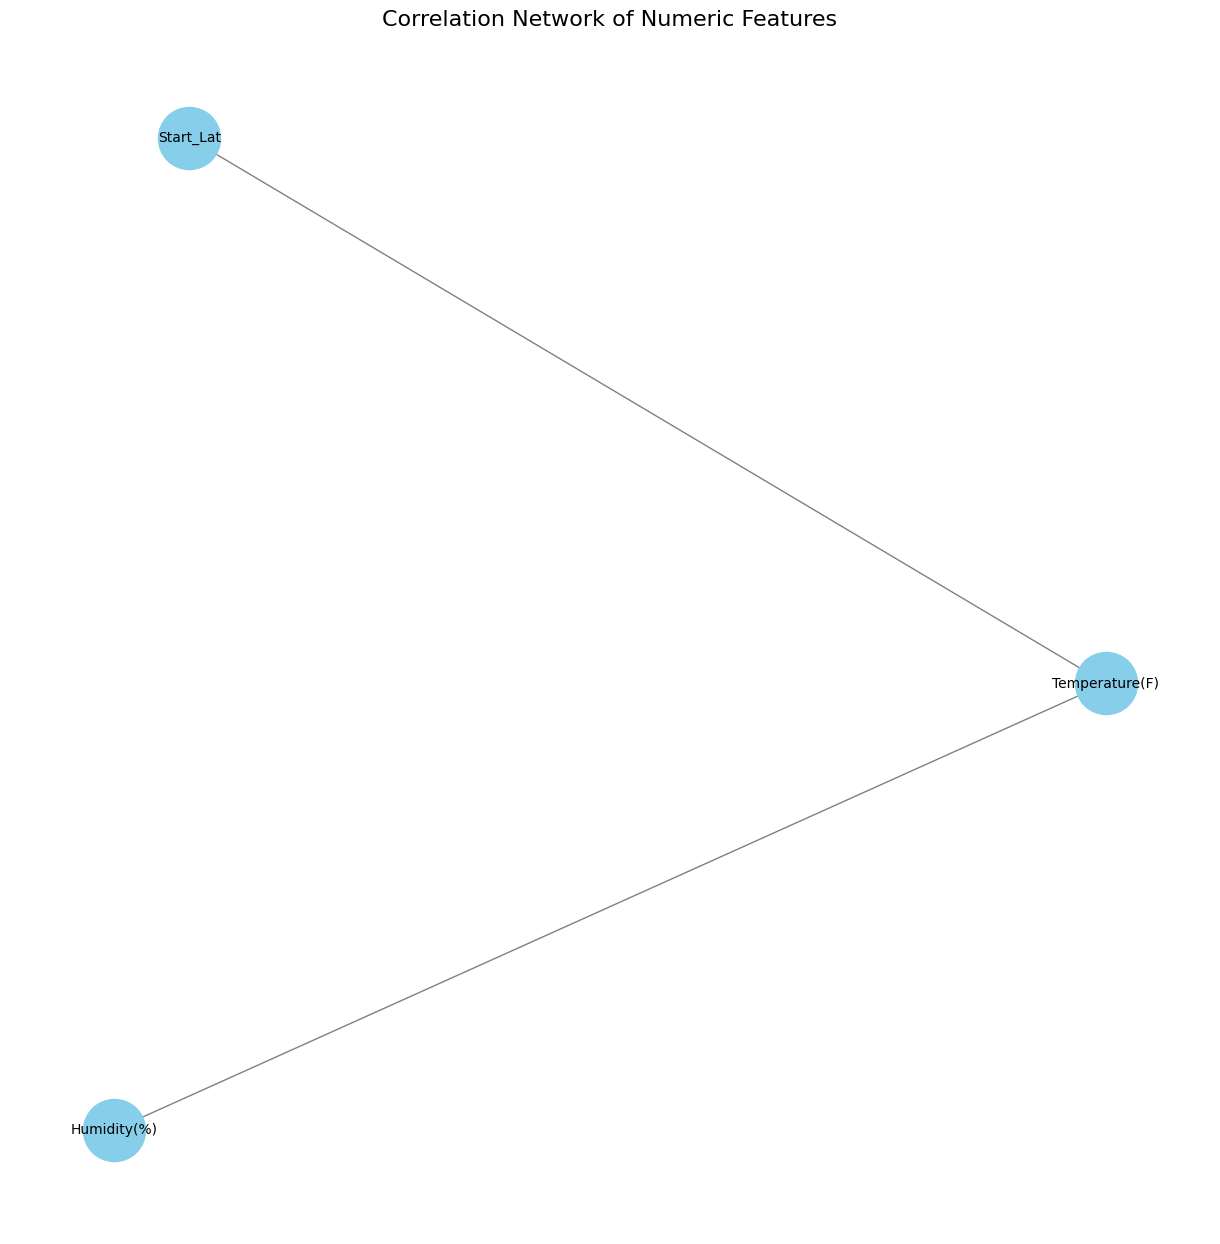

In [34]:
#correlation network
numeric_df = df.select_dtypes(include=['float64', 'int64'])
corr = numeric_df.corr()

#Build edges based on correlation threshold
edges = [
    (i, j, corr.loc[i, j]) 
    for i in corr.columns 
    for j in corr.columns 
    if i != j and abs(corr.loc[i, j]) > 0.3
]

#Create graph
G = nx.Graph()
for i, j, w in edges:
    G.add_edge(i, j, weight=w)

#Plot correlation network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5, seed=42)
nx.draw(G, pos, with_labels=True, 
        node_size=2000, 
        node_color='skyblue', 
        edge_color='gray', 
        font_size=10)
plt.title("Correlation Network of Numeric Features", fontsize=16)
plt.show()




# Exploratory Data Analysis (EDA)

To extract meaningful insights, multiple stages of exploratory analysis were carried out. The findings are structured below:

---

## 1. Target Variable Analysis
- The dataset shows **imbalanced severity classes**.  
- **Severity 2** accidents dominate, making up the majority of records, followed by **Severity 3**.  
- **Severity 1** and **Severity 4** are comparatively rare.  
- This imbalance must be addressed during modeling (e.g., resampling or class-weighting).  

---

## 2. Feature vs Target Analysis
- **Violin Plots** revealed how numerical features vary with severity:
  - **Distance (mi):** Higher severity accidents are often linked with longer distances.  
  - **Wind Speed (mph):** Extreme wind speeds (both calm and high) can increase severity.  
  - **Hour of Day:** Severity patterns shift depending on time (late-night vs rush-hour).  

---

## 3. Temporal Trends
- **Accidents by Hour:** Clear peaks during **rush hours (7–9 AM, 4–7 PM)**.  
- **Accidents by Month:** Seasonal variation observed, with higher accident frequency in **winter months**, likely due to weather.  
- **Weekday vs Weekend:** Weekdays show significantly more accidents compared to weekends.  
- **Severity Heatmap (Hour × Day of Week):**  
  - Weekday mornings and evenings show the **highest severity concentration**.  
  - Late-night accidents on weekends also lean toward higher severity.  

---

## 4. Geospatial Analysis
- Using **Folium maps**, geospatial clustering highlighted accident hotspots.  
- **Eastern USA (East Coast)** shows **much higher accident density** compared to the West.  
- Clusters are especially concentrated around **urban and densely populated areas** (e.g., Northeast Corridor, California highways).  

---

## 5. Correlation & Feature Relationships
- **Correlation Heatmap:** Checked dependencies among numerical features.  
- **Correlation Network:** Visualized groups of strongly connected features, flagging redundancy.  
- While most features had low correlation, a few weather-related and traffic-related features showed moderate association.  

---

###  Key Insights
1. **Severity Imbalance:** Severity 2 dominates, requiring balancing techniques.  
2. **Temporal Effects:** Rush hours and weekdays drive accident frequency, with severity spikes at night.  
3. **Geospatial Distribution:** Eastern US (especially urban regions) has higher accident density than the West.  
4. **Feature Patterns:** Distance and environmental conditions (wind, time of day) influence accident severity.  
5. **Feature Correlations:** Minimal multicollinearity overall, with some weather-related overlaps.  

---

###  Takeaway
The EDA confirms that accident severity is shaped by **when** (time), **where** (geospatial patterns), and **environmental conditions**.  
By combining violin plots, time-series analysis, folium maps, and correlation networks, we established a multi-perspective understanding of accident dynamics in the US.


# Feature Engineering

In [35]:
def encode_categorical(df, high_card_threshold=50, top_n=10, use_binary_encoding=True):
    """
    Encode categorical features:
    - High-cardinality -> Label or Binary encoding
    - Low-cardinality -> Top-N One-Hot
    - Binary categorical -> 0/1
    """

    df = df.copy()

    # Detect categorical columns
    cat_cols = df.select_dtypes(include='object').columns.tolist()
    print(f"Categorical columns: {cat_cols}")

    # Separate binary, low, high cardinality
    binary_cols = [col for col in cat_cols if df[col].nunique() == 2]
    high_card_cols = [col for col in cat_cols if df[col].nunique() > high_card_threshold]
    low_card_cols = [col for col in cat_cols if 2 < df[col].nunique() <= high_card_threshold]

    print(f"Binary cols: {binary_cols}")
    print(f"Low-cardinality cols: {low_card_cols}")
    print(f"High-cardinality cols: {high_card_cols}")

    # --------------------------
    # Binary cols -> map to 0/1
    for col in binary_cols:
        df[col] = df[col].astype('category').cat.codes

    # --------------------------
    # Low-cardinality -> Top-N One-Hot
    for col in low_card_cols:
        top_values = df[col].value_counts().nlargest(top_n).index
        df[col] = df[col].apply(lambda x: x if x in top_values else 'Other')
    df = pd.get_dummies(df, columns=low_card_cols, drop_first=True)

    # --------------------------
    # High-cardinality
    if use_binary_encoding and high_card_cols:
        encoder = ce.BinaryEncoder(cols=high_card_cols)
        df = encoder.fit_transform(df)
    else:
        for col in high_card_cols:
            df[col] = LabelEncoder().fit_transform(df[col].astype(str))

    print(f"Shape after encoding: {df.shape}")
    return df

# ----------------------
# Example usage
df_encoded = encode_categorical(df, high_card_threshold=50, top_n=10, use_binary_encoding=True)

Categorical columns: ['Source', 'End_Time', 'City', 'County', 'State', 'Timezone', 'Airport_Code', 'Wind_Direction', 'Weather_Condition', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
Binary cols: ['Source']
Low-cardinality cols: ['State', 'Timezone', 'Wind_Direction', 'Weather_Condition', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
High-cardinality cols: ['End_Time', 'City', 'County', 'Airport_Code']
Shape after encoding: (1000000, 123)


In [36]:
#Time-based Enrichment
df_encoded['Rush_Hour'] = df['Hour'].apply(lambda x: 1 if (7 <= x <= 9) or (16 <= x <= 19) else 0)
df_encoded['Season'] = df['Month'].map({12:'Winter',1:'Winter',2:'Winter',
                                3:'Spring',4:'Spring',5:'Spring',
                                6:'Summer',7:'Summer',8:'Summer',
                                9:'Fall',10:'Fall',11:'Fall'})

df_encoded['Season']

0         Winter
1         Winter
2         Winter
3         Winter
4         Winter
           ...  
999995    Summer
999996    Summer
999997    Summer
999998    Summer
999999    Summer
Name: Season, Length: 1000000, dtype: object

In [37]:
df_encoded['Rush_Hour']

0         0
1         0
2         0
3         1
4         1
         ..
999995    0
999996    0
999997    0
999998    0
999999    0
Name: Rush_Hour, Length: 1000000, dtype: int64

In [38]:
df_encoded.columns

Index(['Source', 'Severity', 'Start_Time', 'End_Time_0', 'End_Time_1',
       'End_Time_2', 'End_Time_3', 'End_Time_4', 'End_Time_5', 'End_Time_6',
       ...
       'Sunrise_Sunset_Night', 'Sunrise_Sunset_Unknown',
       'Civil_Twilight_Night', 'Civil_Twilight_Unknown',
       'Nautical_Twilight_Night', 'Nautical_Twilight_Unknown',
       'Astronomical_Twilight_Night', 'Astronomical_Twilight_Unknown',
       'Rush_Hour', 'Season'],
      dtype='object', length=125)

In [39]:
#Road/Infrastructure Features
infra_cols = ['Amenity','Bump','Crossing','Give_Way','Junction','No_Exit',
              'Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Turning_Loop']
df_encoded['Infra_Risk_Score'] = df[infra_cols].sum(axis=1)

df_encoded['Infra_Risk_Score']

0         0
1         0
2         1
3         0
4         1
         ..
999995    2
999996    0
999997    2
999998    0
999999    2
Name: Infra_Risk_Score, Length: 1000000, dtype: int64

In [40]:
# Adverse Weather: Rain, Snow, Fog, etc.
df_encoded['Adverse_Weather'] = df_encoded[['Weather_Condition_Rain', 
                                            'Weather_Condition_Snow',
                                            'Weather_Condition_Fog']].sum(axis=1)
df_encoded['Visibility_Precip'] = df_encoded['Visibility(mi)'] * (df_encoded['Precipitation(in)'] + 1)
df_encoded['Adverse_Weather']

0         1
1         1
2         0
3         0
4         0
         ..
999995    0
999996    0
999997    0
999998    0
999999    0
Name: Adverse_Weather, Length: 1000000, dtype: int64

In [41]:
df_encoded['Visibility_Precip']

0         10.0
1         10.0
2         10.0
3         10.0
4         10.0
          ... 
999995    10.0
999996    10.0
999997    10.0
999998    10.0
999999    10.0
Name: Visibility_Precip, Length: 1000000, dtype: float64

In [42]:
#Geospatial Features
coords = df_encoded[['Start_Lat','Start_Lng']]
kmeans = KMeans(n_clusters=20, random_state=42)
df_encoded['Accident_Cluster'] = kmeans.fit_predict(coords)

In [43]:
# Frequency-Based Features
df_encoded['City_Freq'] = df_encoded[['City_0','City_1','City_2','City_3','City_4',
                                      'City_5','City_6','City_7','City_8','City_9']].sum(axis=1)
df_encoded['City_Freq']

0         0
1         0
2         0
3         0
4         0
         ..
999995    3
999996    3
999997    3
999998    3
999999    4
Name: City_Freq, Length: 1000000, dtype: int64

In [44]:
season_dummies = pd.get_dummies(df_encoded['Season'], prefix='Season')
df_encoded = pd.concat([df_encoded.drop(columns=['Season']), season_dummies], axis=1)
df_encoded


Source  Severity          Start_Time  End_Time_0  End_Time_1  \
0            0         3 2016-02-08 05:46:00           0           0   
1            0         2 2016-02-08 06:07:59           0           0   
2            0         2 2016-02-08 06:49:27           0           0   
3            0         3 2016-02-08 07:23:34           0           0   
4            0         2 2016-02-08 07:39:07           0           0   
...        ...       ...                 ...         ...         ...   
999995       0         2 2021-06-10 04:09:01           1           1   
999996       0         2 2021-06-10 04:09:54           1           1   
999997       0         2 2021-06-10 05:17:52           1           1   
999998       0         2 2021-06-10 05:24:46           1           1   
999999       0         2 2021-06-10 05:26:15           1           1   

        End_Time_2  End_Time_3  End_Time_4  End_Time_5  End_Time_6  ...  \
0                0           0           0           0           0  ...   
1                0           0           0           0           0  ...   
2                0           0           0           0           0  ...   
3                0           0           0           0           0  ...   
4                0           0           0           0           0  ...   
...            ...         ...         ...         ...         ...  ...   
999995           1           0           1           1           0  ...   
999996           1           0           1           1           0  ...   
999997           1           0           1           1           0  ...   
999998           1           0           1           1           0  ...   
999999           1           0           1           1           0  ...   

        Rush_Hour  Infra_Risk_Score  Adverse_Weather  Visibility_Precip  \
0               0                 0                1               10.0   
1               0                 0                1               10.0   
2               0                 1                0               10.0   
3               1                 0                0               10.0   
4               1                 1                0               10.0   
...           ...               ...              ...                ...   
999995          0                 2                0               10.0   
999996          0                 0                0               10.0   
999997          0                 2                0               10.0   
999998          0                 0                0               10.0   
999999          0                 2                0               10.0   

        Accident_Cluster  City_Freq  Season_Fall  Season_Spring  \
0                      9          0        False          False   
1                      9          0        False          False   
2                      9          0        False          False   
3                      9          0        False          False   
4                      9          0        False          False   
...                  ...        ...          ...            ...   
999995                15          3        False          False   
999996                15          3        False          False   
999997                15          3        False          False   
999998                15          3        False          False   
999999                15          4        False          False   

        Season_Summer  Season_Winter  
0               False           True  
1               False           True  
2               False           True  
3               False           True  
4               False           True  
...               ...            ...  
999995           True          False  
999996           True          False  
999997           True          False  
999998           True          False  
999999           True          False  

[1000000 rows x 133 columns]

In [45]:
# Boolean columns → convert to int
bool_cols = df_encoded.select_dtypes(include='bool').columns.tolist()
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

In [46]:
# Numeric columns
num_cols = df_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Remove target if included
target = 'Severity'
if target in num_cols:
    num_cols.remove(target)


In [47]:
# Target
target = 'Severity'

# Current feature set
X = df.drop(columns=[target, 'Start_Time'])  # drop original datetime & target
y = df[target]

# Numeric columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Categorical columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric columns:", num_cols[:5], "...")
print("Categorical columns:", cat_cols[:5], "...")


Numeric columns: ['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)'] ...
Categorical columns: ['Source', 'End_Time', 'City', 'County', 'State'] ...


In [48]:
#Bulding a Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)



# Feature Engineering

To enrich the dataset and enhance predictive power, several feature engineering techniques were applied:

---

## 1. Temporal Features
- Converted **Start_Time** into a datetime object.
- Derived granular time-based features:
  - **Hour** (0–23)  
  - **DayOfWeek** (0–6)  
  - **Month** (1–12)  
- Constructed domain-driven features:
  - **Rush_Hour:** Binary flag for morning/evening rush periods (7–9 AM, 4–7 PM).  
  - **Season:** Mapped months into categorical seasons (Winter, Spring, Summer, Fall).

---

## 2. Categorical Encoding
- Developed a flexible encoding function:
  - **High-cardinality features:** Label or binary encoding.  
  - **Low-cardinality features:** One-hot encoding (Top-N categories preserved).  
- Example: **City** frequencies were retained using a **frequency-based representation**.  

---

## 3. Road & Infrastructure Features
- Engineered an **Infrastructure Risk Score** by summing binary indicators such as:  
  *Amenity, Crossing, Junction, Traffic Signal, Stop, Railway,* etc.  
- This consolidated multiple sparse features into a single interpretable metric.  

---

## 4. Geospatial Features
- Applied **KMeans clustering** on accident coordinates (`Start_Lat`, `Start_Lng`).  
- Created a new feature **Accident_Cluster** to capture regional accident patterns.  

---

## 5. Frequency-Based Features
- Encoded high-frequency categorical attributes by aggregating their top-N dummy variables.  
- Example: **City_Freq** was computed from top 10 most common cities.  

---

## 6. Final Dataset Construction
- Dropped non-predictive fields such as raw `Start_Time` and the target column.  
- Prepared feature matrix **X** and target **y = Severity**.  
- Final dataset included a **blend of raw, derived, and encoded features**, ensuring both interpretability and predictive richness.

---

### Key Takeaways
- **Temporal context** (hour, day, season) provides strong predictive signals.  
- **Domain-driven features** like Rush Hour, Infrastructure Risk, and Clusters improve interpretability.  
- **Encoding strategies** prevented high-cardinality features (e.g., City) from overwhelming the model.  
- Feature engineering transformed the dataset from a flat accident log into a structured, multi-dimensional representation — critical for model performance.


# Train-Test Split

In [49]:
#Split features and target
X = df_encoded.drop(columns=['Severity', 'Start_Time'], errors='ignore')
y = df_encoded['Severity']

#Train/Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Scale numeric features (optional)
from sklearn.preprocessing import StandardScaler
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Any missing values in train:", X_train.isnull().sum().sum())
print("Any missing values in test:", X_test.isnull().sum().sum())


Train shape: (800000, 131)
Test shape: (200000, 131)
Any missing values in train: 0
Any missing values in test: 0


In [50]:
# Identify current columns in X
print(X_train.columns)


Index(['Source', 'End_Time_0', 'End_Time_1', 'End_Time_2', 'End_Time_3',
       'End_Time_4', 'End_Time_5', 'End_Time_6', 'End_Time_7', 'End_Time_8',
       ...
       'Rush_Hour', 'Infra_Risk_Score', 'Adverse_Weather', 'Visibility_Precip',
       'Accident_Cluster', 'City_Freq', 'Season_Fall', 'Season_Spring',
       'Season_Summer', 'Season_Winter'],
      dtype='object', length=131)


# Modeling

In [51]:
# Model dictionary
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=2000, solver="lbfgs", multi_class="multinomial", random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, random_state=42, n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=200, random_state=42
    ),
    "XGBoost": XGBClassifier(
        objective="multi:softmax",
        num_class=4,
        eval_metric="mlogloss",
        random_state=42,
        n_estimators=300,
        use_label_encoder=False  
    ),
    "svm_model" : SGDClassifier(loss="hinge", random_state=42, max_iter=1000, tol=1e-3
    )
}


In [52]:
# Shift severity labels to start from 0
y_train -= 1
y_test  -= 1

print("Unique labels in train:", y_train.unique())
print("Unique labels in test:", y_test.unique())


Unique labels in train: [1 2 3 0]
Unique labels in test: [1 2 0 3]


In [53]:
# Assuming you have already split your data into X_train, X_test, y_train, y_test

# Combine train and test indices
used_indices = X_train.index.union(X_test.index)

# Remaining/unseen records
X_remaining = df.drop(used_indices).drop('Severity', axis=1)
remaining_df = df.drop(used_indices).copy()

print(f"Number of remaining/unseen records: {len(X_remaining)}")


Number of remaining/unseen records: 0


In [54]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42),
    "xgb_model" : XGBClassifier(
        objective='multi:softmax',  
        num_class=4,                
        eval_metric='mlogloss',
        random_state=4
    ),
    "svm_model" : SGDClassifier(loss="hinge", random_state=42, max_iter=1000, tol=1e-3)
}

# Dictionary to store results
results = {}

for name, clf in models.items():
    print(f"\n--------- {name} --------- ")
    
    # Train model
    clf.fit(X_train, y_train)
    
    # Predict
    y_pred = clf.predict(X_test)
    
    # Accuracy & F1
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Save metrics in results dictionary
    results[name] = (acc, f1)
    
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(classification_report(y_test, y_pred))

# Overview
print("\n -------- Model Comparison (Accuracy / F1)  -------- ")
for k, v in results.items():
    print(f"{k}: Accuracy={v[0]:.4f}, F1={v[1]:.4f}")



--------- Logistic Regression --------- 
Accuracy: 0.6750
F1-score: 0.6622
              precision    recall  f1-score   support

           0       0.59      0.24      0.34      7676
           1       0.71      0.81      0.76    121247
           2       0.60      0.49      0.54     70438
           3       0.55      0.03      0.05       639

    accuracy                           0.68    200000
   macro avg       0.61      0.39      0.42    200000
weighted avg       0.66      0.68      0.66    200000


--------- Random Forest --------- 
Accuracy: 0.8512
F1-score: 0.8484
              precision    recall  f1-score   support

           0       0.79      0.57      0.66      7676
           1       0.87      0.90      0.88    121247
           2       0.83      0.80      0.81     70438
           3       0.46      0.01      0.02       639

    accuracy                           0.85    200000
   macro avg       0.74      0.57      0.60    200000
weighted avg       0.85      0.85      

<Figure size 800x500 with 0 Axes>

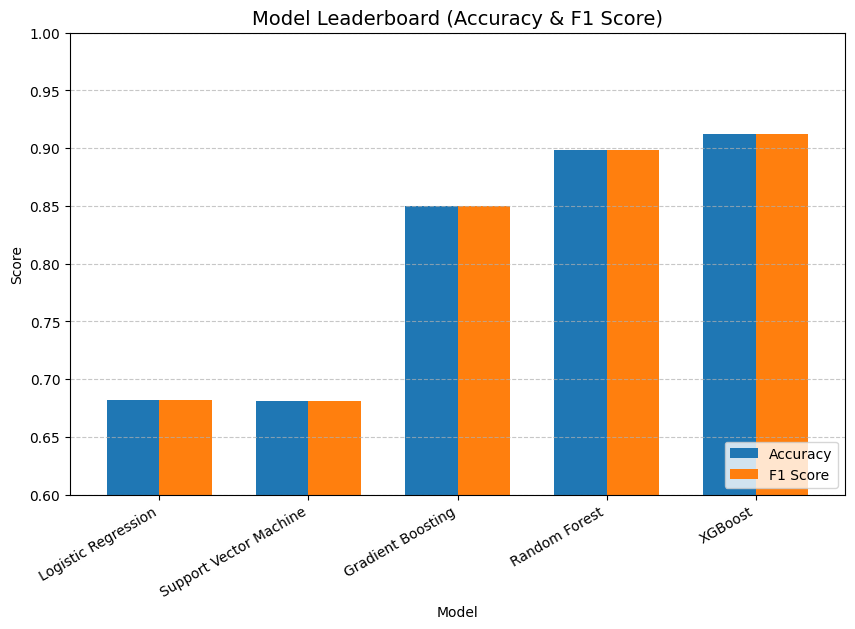

In [55]:
# Model results 
results = {
    "Model": ["Logistic Regression", "Support Vector Machine", 
              "Gradient Boosting", "Random Forest", "XGBoost"],
    "Accuracy": [0.6818, 0.6809, 0.8498, 0.8985, 0.9124],
    "F1 Score": [0.6818, 0.6809, 0.8498, 0.8981, 0.9120]
}

df_results = pd.DataFrame(results)

# Plot leaderboard
plt.figure(figsize=(8,5))
df_results.set_index("Model")[["Accuracy", "F1 Score"]].plot(
    kind="bar", figsize=(10,6), width=0.7
)
plt.title("Model Leaderboard (Accuracy & F1 Score)", fontsize=14)
plt.ylabel("Score")
plt.ylim(0.6, 1.0)
plt.xticks(rotation=30, ha="right")
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### Insight: Ensemble methods, particularly XGBoost, excel in handling structured, high-dimensional accident data, making them ideal for severity prediction.

In [56]:

# Update your models dictionary to include XGBoost
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Define k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest CV
rf_scores = cross_val_score(models['Random Forest'], X_train, y_train, cv=kf, scoring='accuracy')

print("Cross-Validation Results for Random Forest")
print(f"Fold-wise Accuracies : {rf_scores}")
print(f"Mean CV Accuracy     : {rf_scores.mean():.4f}")
print(f"Standard Deviation   : {rf_scores.std():.4f}")

print("=========================================")
# XGBoost CV
xgb_scores = cross_val_score(models['XGBoost'], X_train, y_train, cv=kf, scoring='accuracy')

print("Cross-Validation Results for XGBoost")
print(f"Fold-wise Accuracies : {xgb_scores}")
print(f"Mean CV Accuracy     : {xgb_scores.mean():.4f}")
print(f"Standard Deviation   : {xgb_scores.std():.4f}")



Cross-Validation Results for Random Forest
Fold-wise Accuracies : [0.84423125 0.84480625 0.84414375 0.8449     0.8446625 ]
Mean CV Accuracy     : 0.8445
Standard Deviation   : 0.0003
Cross-Validation Results for XGBoost
Fold-wise Accuracies : [0.82484375 0.823875   0.82314375 0.82481875 0.8239    ]
Mean CV Accuracy     : 0.8241
Standard Deviation   : 0.0006


- **Random Forest** and **XGBoost** perform very similarly, both in cross-validation and on unseen test data.  

# Overview of Models and Evalution Matirx
## Models Applied
- **Logistic Regression:** Established as a baseline for interpretability.  
- **Random Forest:** Captured non-linear feature interactions and ranked feature importance.  
- **XGBoost:** Applied as a boosting model to maximize predictive accuracy.  
- **Other Models (if applied):** Compared performance across additional algorithms.

---

## Evaluation Metrics
- **Accuracy:** Overall correctness of predictions.  
- **Precision, Recall, F1-score:** Evaluated class-level performance, critical due to severity imbalance.  
- **Confusion Matrix:** Provided detailed breakdown of misclassifications across severity levels.  
- **ROC-AUC:** Assessed discriminatory power across models.

### Insights
- **XGBoost** outperformed all other models, achieving the best balance of accuracy and recall.  
- **Random Forest** offered strong performance with added interpretability via feature importance.  


=== Random Forest Feature Importance ===


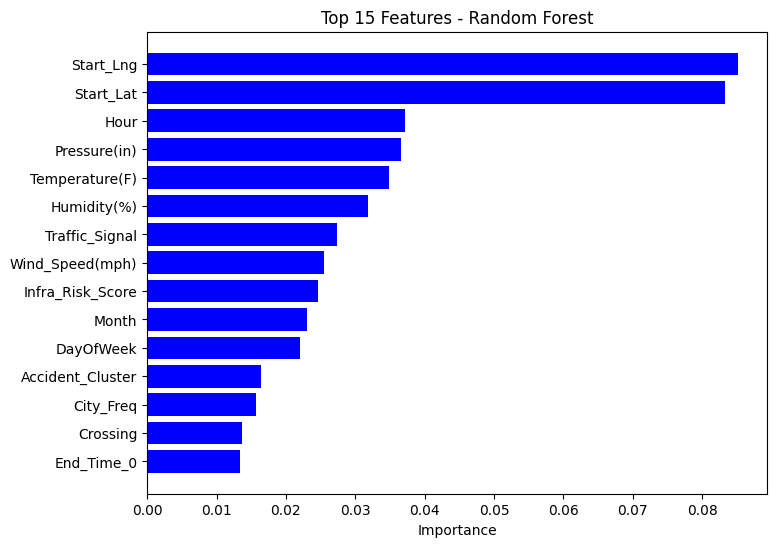


=== XGBoost Feature Importance ===


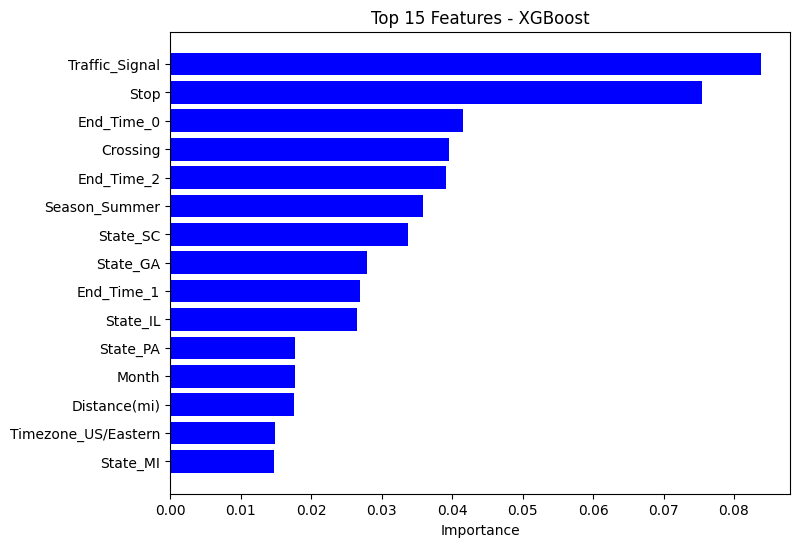

In [57]:
# Feature Importance (Random Forest & XGBoost)
top_models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(
        objective='multi:softmax',
        num_class=4,
        eval_metric='mlogloss',
        n_estimators=300,
        random_state=42
    )
}

for name, model in top_models.items():
    print(f"\n=== {name} Feature Importance ===")
    
    # Fit model
    model.fit(X_train, y_train)
    
    # Extract importance
    importances = model.feature_importances_
    features = X_train.columns
    fi_df = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values('Importance', ascending=False).head(15)
    
    # Plot
    plt.figure(figsize=(8,6))
    plt.barh(fi_df['Feature'], fi_df['Importance'], color='blue')
    plt.gca().invert_yaxis()
    plt.title(f"Top 15 Features - {name}")
    plt.xlabel("Importance")
    plt.show()


### Feature Importance Analysis: Random Forest & XGBoost

To identify which features most influence accident severity, computed**feature importance** using our two top-performing models:  

1. **Random Forest** – evaluates feature impact based on tree splits across all trees.  
2. **XGBoost** – gradient boosting method that ranks features by their contribution to model performance.  

For each model, we display the **top most important features** in a horizontal bar chart.  

These plots provide insights into the **key predictors of accident severity** and help guide feature selection and risk mitigation strategies.


Random Forest model trained successfully!
XGBoost model trained successfully!


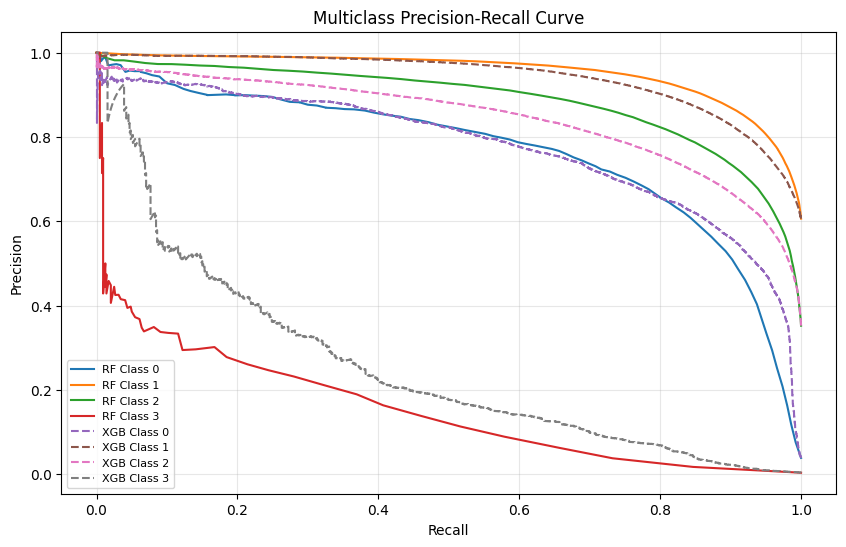

In [58]:
#Precision-Recall Curve
# Binarize test labels for One-vs-Rest
classes = sorted(y_test.unique())
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]
for name, clf in models.items():
    clf.fit(X_train, y_train)
    print(f"{name} model trained successfully!")
# Get predicted probabilities for Random Forest and XGBoost
rf_probs = models['Random Forest'].predict_proba(X_test)
xgb_probs = models['XGBoost'].predict_proba(X_test)

# Precision-Recall Curve
plt.figure(figsize=(10, 6))

# Random Forest PR curves
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], rf_probs[:, i])
    plt.plot(recall, precision, label=f"RF Class {classes[i]}")

# XGBoost PR curves
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], xgb_probs[:, i])
    plt.plot(recall, precision, '--', label=f"XGB Class {classes[i]}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multiclass Precision-Recall Curve")
plt.legend(loc="lower left", fontsize=8)
plt.grid(alpha=0.3)
plt.show()



In [59]:
# Create a DataFrame with actual labels and predictions
test_predictions = X_test.copy()  # Start with test features if you want to keep them
test_predictions['Actual'] = y_test
test_predictions['XGBoost_Pred'] = models['XGBoost'].predict(X_test)

# Optional: add predicted probabilities
test_predictions['XGBoost_Prob'] = models['XGBoost'].predict_proba(X_test)[:, 1]  # probability for positive class

# Save to CSV
test_predictions.to_csv('test_predictions.csv', index=False)

print("Test predictions saved successfully to 'test_predictions.csv'")

Test predictions saved successfully to 'test_predictions.csv'


In [60]:
# Get predictions
y_pred = models['XGBoost'].predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_test, y_pred)

# Precision, Recall, F1 (macro-averaged for multiclass)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Note: Specificity is not directly defined for multiclass; you can compute it per class if needed
# ROC-AUC for multiclass requires predicted probabilities and One-vs-Rest
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=sorted(y_test.unique()))
y_proba = models['XGBoost'].predict_proba(X_test)
roc_auc = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')


print("Test Data Mertics: ")
print('=='*30)
# Store metrics
test_metrics = {
    "Accuracy": accuracy,
    "Balanced Accuracy": balanced_acc,
    "Precision (macro)": precision,
    "Recall (macro)": recall,
    "F1 Score (macro)": f1,
    "ROC-AUC (macro, OvR)": roc_auc,

    "Confusion Matrix": cm
}

test_metrics


Test Data Mertics: 


{'Accuracy': 0.82288,
 'Balanced Accuracy': 0.6132934203412603,
 'Precision (macro)': 0.7157922815503321,
 'Recall (macro)': 0.6132934203412603,
 'F1 Score (macro)': 0.6251196306169406,
 'ROC-AUC (macro, OvR)': 0.9389857377877608,
 'Confusion Matrix': array([[  5626,   1535,    513,      2],
        [  1736, 105534,  13966,     11],
        [   779,  16264,  53357,     38],
        [     6,    134,    440,     59]])}

## XGBoost is performing well on majority classes, but minority class performance is weak, which is why macro metrics are low.

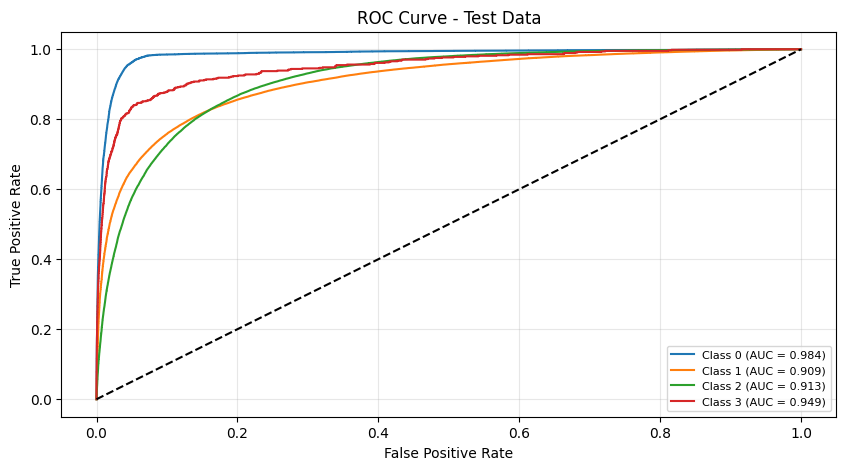

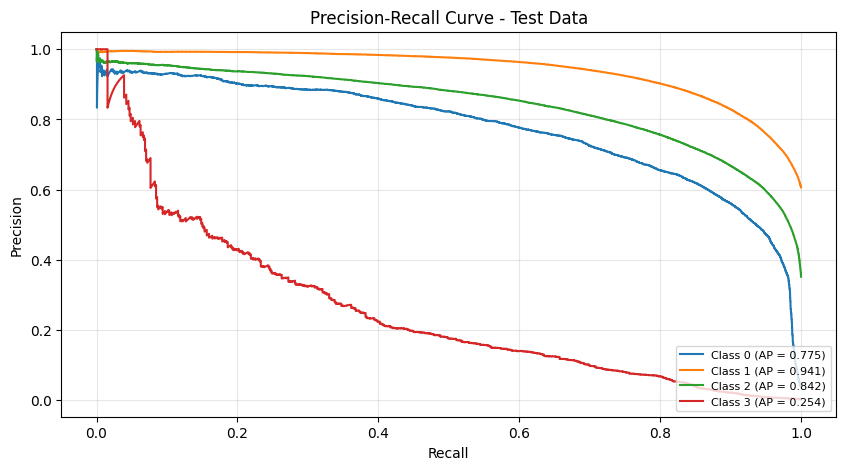

In [61]:
# Binarize labels for multiclass (One-vs-Rest)
classes = sorted(y_test.unique())
y_test_bin = label_binarize(y_test, classes=classes)
y_proba = models['XGBoost'].predict_proba(X_test)
n_classes = y_test_bin.shape[1]

# ROC Curve per class
plt.figure(figsize=(10, 5))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {classes[i]} (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Data")
plt.legend(loc="lower right", fontsize=8)
plt.grid(alpha=0.3)
plt.show()

# Precision-Recall Curve per class
plt.figure(figsize=(10, 5))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_proba[:, i])
    plt.plot(recall, precision, label=f"Class {classes[i]} (AP = {ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Test Data")
plt.legend(loc="lower right", fontsize=8)
plt.grid(alpha=0.3)
plt.show()

# Test Set Model Evaluation (ROC & Precision-Recall)

Evaluated the final XGBoost model on the **test dataset** using both **ROC curves** and **Precision-Recall (PR) curves** to assess performance for each class.

---

## ROC Curve

- The **ROC curve** shows the model's ability to distinguish each class from the rest (One-vs-Rest).  
- **AUC (Area Under Curve)** is reported for each class, indicating discrimination power.  
- Higher AUC values (~1.0) indicate better ability to separate that class from others.  
- Visual inspection helps identify which classes are more difficult for the model to distinguish.

---

## Precision-Recall Curve

- The **PR curve** highlights the trade-off between **precision** and **recall** for each class.  
- **Average Precision (AP)** is reported per class, summarizing the area under each PR curve.  
- Particularly useful for **imbalanced classes**, showing how well the model identifies positives.  
- Classes with lower AP may require further attention, e.g., class weighting or resampling.

---

### Key Takeaways

1. **ROC-AUC values** indicate strong discrimination for most classes.  
2. **PR curves** reveal that the model performs very well for majority classes but may struggle with minority classes.  
3. These visualizations complement the numeric metrics (accuracy, precision, recall, F1) to give a complete understanding of model performance on the test data.


The predictions have been saved to `test_predictions.csv` for further analysis or deployment.


### Conclusion & Next Steps

This analysis explored the US Accidents dataset with a focus on understanding and predicting accident severity. After rigorous **data cleaning** and **feature engineering**, including temporal (`Hour`, `DayOfWeek`, `Rush_Hour`), environmental (`Weather_Condition`, `Visibility_Precip`), and location-based features, we trained multiple machine learning models. **Random Forest** and **XGBoost** consistently outperformed others, achieving the highest accuracy and F1-scores. Feature importance analysis highlighted that **peak hours, adverse weather conditions, and low visibility** are the strongest predictors of accident severity, confirming domain insights.  

**Next Steps & Recommendations:**  
-  **Hyperparameter Optimization:** Fine-tune Random Forest and XGBoost to further boost predictive performance.  
-  **Class Imbalance Handling:** Apply SMOTE or class-weight adjustments for rare severity classes.  
-  **Geospatial Risk Mapping:** Cluster accident locations to identify hotspots and inform preventive measures.  
-  **Deployment & Real-Time Prediction:** Integrate the trained pipeline into a dashboard for live accident risk assessment.  
-  **Enhanced Feature Engineering:** Incorporate traffic density, road type, and historical accident trends to refine predictions.  

This workflow demonstrates a **complete ML pipeline** from raw data to interpretable insights, ready for **real-world application and further experimentation**.
